In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML,clear_output
# display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import os

from seislab.src import segyrw
from seislab.src import plot_seismic as ps
from seislab.src import dsp

In [3]:
folder = '../Data/Data/Datasets_Microseismic/Weatherford/RawData/233'
files_list = os.listdir(folder)
file_name = os.path.join(folder, files_list[0])
segyrw.read_textual_header(file_name)

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Data/Datasets_Microseismic/Weatherford/RawData/233'

In [15]:
trace_descriptor = {'YearDataRecorded': {'pos': 156, 'type': 'h'},
 'DayOfYear': {'pos': 158, 'type': 'h'},
 'HourOfDay': {'pos': 160, 'type': 'h'},
 'MinuteOfHour': {'pos': 162, 'type': 'h'},
 'SecondOfMinute': {'pos': 164, 'type': 'h'},
 'PWave': {'pos': 181, 'type': 'h'},
 'SWave': {'pos': 185, 'type': 'h'},
 'MiliOfSecond': {'pos': 104, 'type': 'h'},
}

In [16]:
dt = .00025
band = [80., 100., 400., 500.]

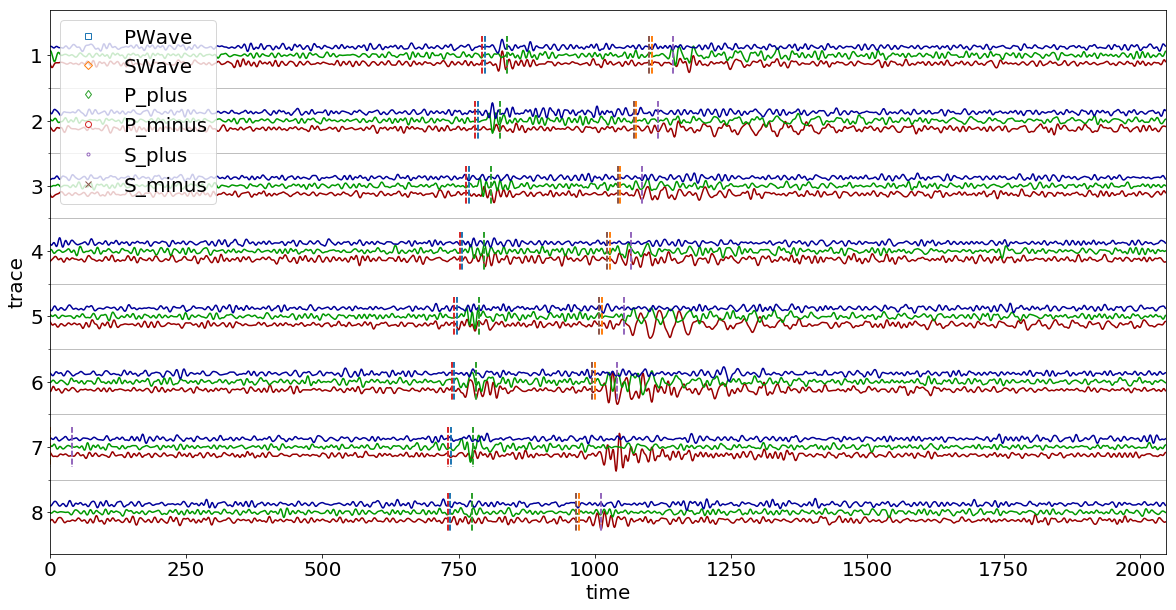

In [44]:
trace_header = segyrw.read_trace_header(file_name,trace_descriptor=trace_descriptor)
traces = segyrw.read_traces(file_name, verbose=False)
traces = dsp.apply_band_pass(traces, dt, band)
traces = dsp.cast_to_3c_traces(traces)

# pd.DataFrame.from_dict(trace_header)
interval_plus = 40
interval_minus = 5
picks = {k: trace_header[k][::3] for k in ['PWave', 'SWave']}
picks['P_plus'] = [x + interval_plus for x in picks['PWave']]
picks['P_minus'] = [x - interval_minus for x in picks['PWave']]

picks['S_plus'] = [x + interval_plus for x in picks['SWave']]
picks['S_minus'] = [x - interval_minus for x in picks['SWave']]
ps.plot_traces(
    traces,
    picks=picks,
    fig_width=20,
)

# Hodogram

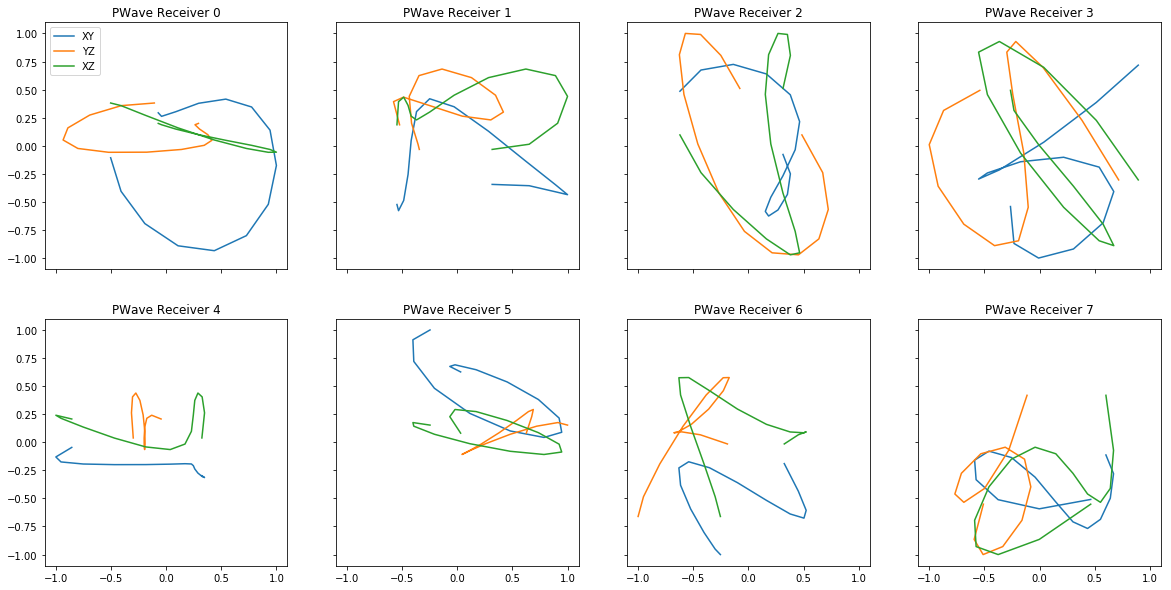

In [18]:
interval_plus = 10
interval_minus = 5

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True, sharey=True)
axs = axs.ravel()

for i, (center, trace) in enumerate(zip(picks['PWave'], traces)):
    if center - interval_minus < 0:
        continue
    hodogram = dsp.cut_trigger_from_traces(
        trace, 
        center, 
        before=interval_plus, 
        after=interval_minus,
        dt=1,
        axis=0,
    )
    hodogram /=  np.nanmax(np.abs(hodogram))
    
    axs[i].plot(hodogram[:,0], hodogram[:,1], label='XY')
    axs[i].plot(hodogram[:,1], hodogram[:,2], label='YZ')
    axs[i].plot(hodogram[:,0], hodogram[:,2], label='XZ')
    axs[i].set_title('PWave Receiver ' + str(i))
    if i == 0:
        axs[i].legend(loc=2)

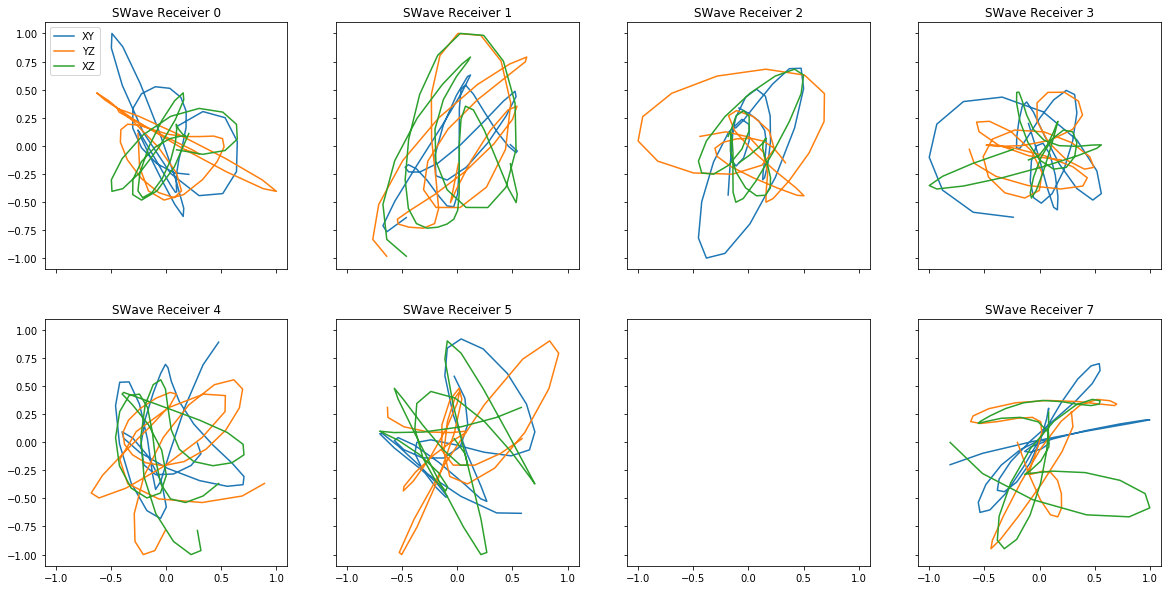

In [19]:
interval_plus = 40
interval_minus = 5

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True, sharey=True)
axs = axs.ravel()

for i, (center, trace) in enumerate(zip(picks['SWave'], traces)):
    if center - interval_minus < 0:
        continue
    hodogram = dsp.cut_trigger_from_traces(
        trace, 
        center, 
        before=interval_plus, 
        after=interval_minus,
        dt=1,
        axis=0,
    )
    hodogram /=  np.nanmax(np.abs(hodogram))
    
    axs[i].plot(hodogram[:,0], hodogram[:,1], label='XY')
    axs[i].plot(hodogram[:,1], hodogram[:,2], label='YZ')
    axs[i].plot(hodogram[:,0], hodogram[:,2], label='XZ')
    axs[i].set_title('SWave Receiver ' + str(i))
    if i == 0:
        axs[i].legend(loc=2)

# Polarization Analysis

In [60]:
def polarization_analysis(hodogram):

    _, eig_val, eig_vec = np.linalg.svd(hodogram)
    eig_val = eig_val ** 2
    eig_val = eig_val / np.nanmax(eig_val)
    
    eig_idx = np.argsort(eig_val)[::-1]
    eig_val = eig_val[eig_idx]
    eig_vec = eig_vec[eig_idx]

    vector3 = np.cross(eig_vec[:, 0], eig_vec[:, 1])
    dot_prod = np.dot(vector3, eig_vec[:, 2])
    
    if dot_prod > 0:
        eig_vec[:, 2] *= -1

    polarization = eig_vec
    this_rot = polarization
    
    polar_angle = np.abs(np.arctan2(np.linalg.norm(this_rot[:1, 0]), this_rot[2, 0]))
    # % PolarAng = acos(this_rot(3, jw) / norm(this_rot(:, jw), 2));
    azimuth = np.arctan2(this_rot[1, 0], this_rot[0, 0])
    
    azm_vec = np.array([-this_rot[1, 0], this_rot[0, 0], 0])
    pol_vec = np.cross(azm_vec, this_rot[:, 0])
    nrm_val = np.pi * eig_val / np.max(eig_val)
    
    polar_angle_std = np.abs(np.dot(pol_vec, nrm_val[1] * this_rot[:, 1])) + \
                        np.abs(np.dot(pol_vec, nrm_val[2] * this_rot[:, 2]))
    
    azimuth_std = np.abs(np.dot(azm_vec, nrm_val[1] * this_rot[:, 1])) + \
                    np.abs(np.dot(azm_vec, nrm_val[2] * this_rot[:, 2]))
    linearity = ((eig_val[0] - eig_val[1]) ** 2 + (eig_val[0] - eig_val[2]) ** 2 + 
                 (eig_val[1] - eig_val[2]) ** 2) / (2 * sum(eig_val) ** 2)
    
    return polarization, azimuth, azimuth_std, polar_angle, polar_angle_std, linearity

In [61]:
interval_plus = 10
interval_minus = 5


pol_an_result = []
for i, (center, trace) in enumerate(zip(picks['PWave'], traces)):
    if center - interval_minus < 0:
        continue
    hodogram = dsp.cut_trigger_from_traces(
        trace, 
        center, 
        before=interval_plus, 
        after=interval_minus,
        dt=1,
        axis=0,
    )
    tmp = polarization_analysis(hodogram)
    pol_an_result.append(tmp[1:])

pol_an_result = dict(
    zip(
        ['polarization', 'azimuth', 'azimuth_std', 'polar_angle', 'polar_angle_std', 'linearity'], 
        pol_an_result
    )
)

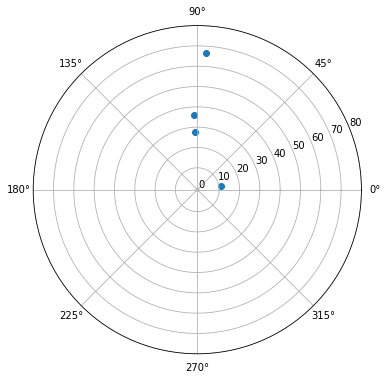

In [62]:
fig = plt.figure(figsize=(20,20), facecolor='w') 
ax = fig.add_subplot(133, polar=True)

ax.scatter(pol_an_result['azimuth'], np.rad2deg(pol_an_result['polar_angle']))
el = np.arange(0, 90, 10)
ax.set_rticks(el)

plt.show()

# Rotation of Traces

In [71]:
traces_rot = traces.copy()
for i, (center, trace) in enumerate(zip(picks['PWave'], traces)):
    if center - interval_minus < 0:
        continue
    hodogram = dsp.cut_trigger_from_traces(
        trace.copy(), 
        center, 
        before=interval_plus, 
        after=interval_minus,
        dt=1,
        axis=0,
    )
    tmp = polarization_analysis(hodogram)
    rotation_matrix = tmp[0]
    traces_rot[i] = trace.dot(rotation_matrix)

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


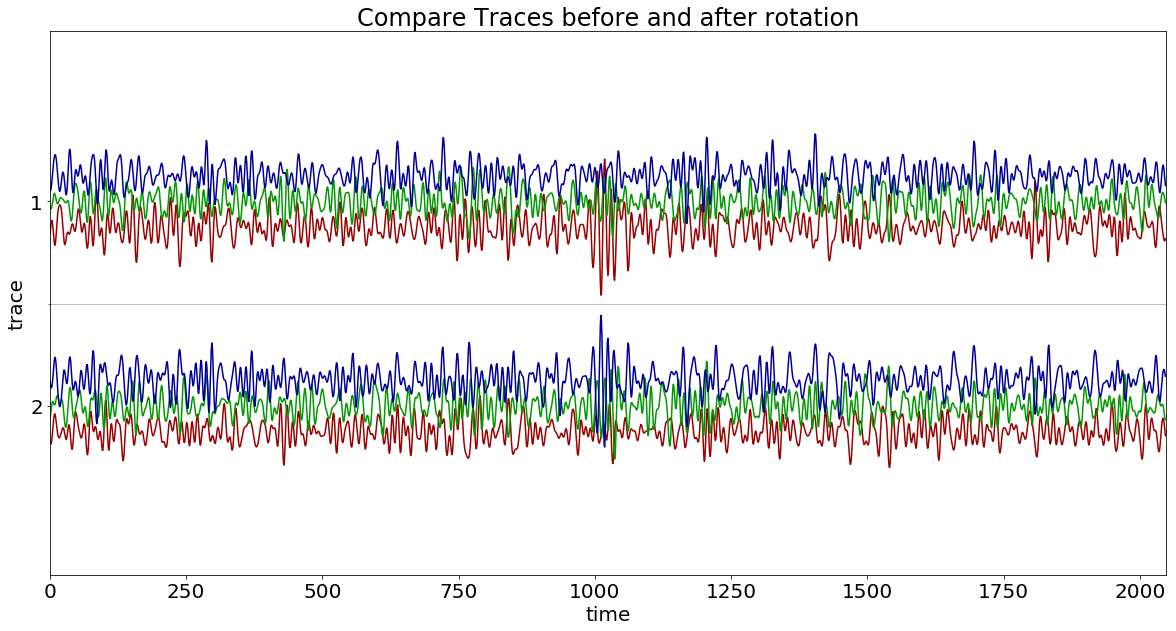

In [72]:
ps.plot_traces(
    np.stack([traces[7], traces_rot[7]]),
#     picks=picks,
    fig_width=20,
    title='Compare Traces before and after rotation'
)